In [ ]:
!pip install transformers datasets accelerate
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from transformers import AutoTokenizer, AutoModelForCausalLM

warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 439.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

# 1. Vanila Transformer Pytorch로 직접 구현해보기

- Encode - Decoder 구조
- self-attention


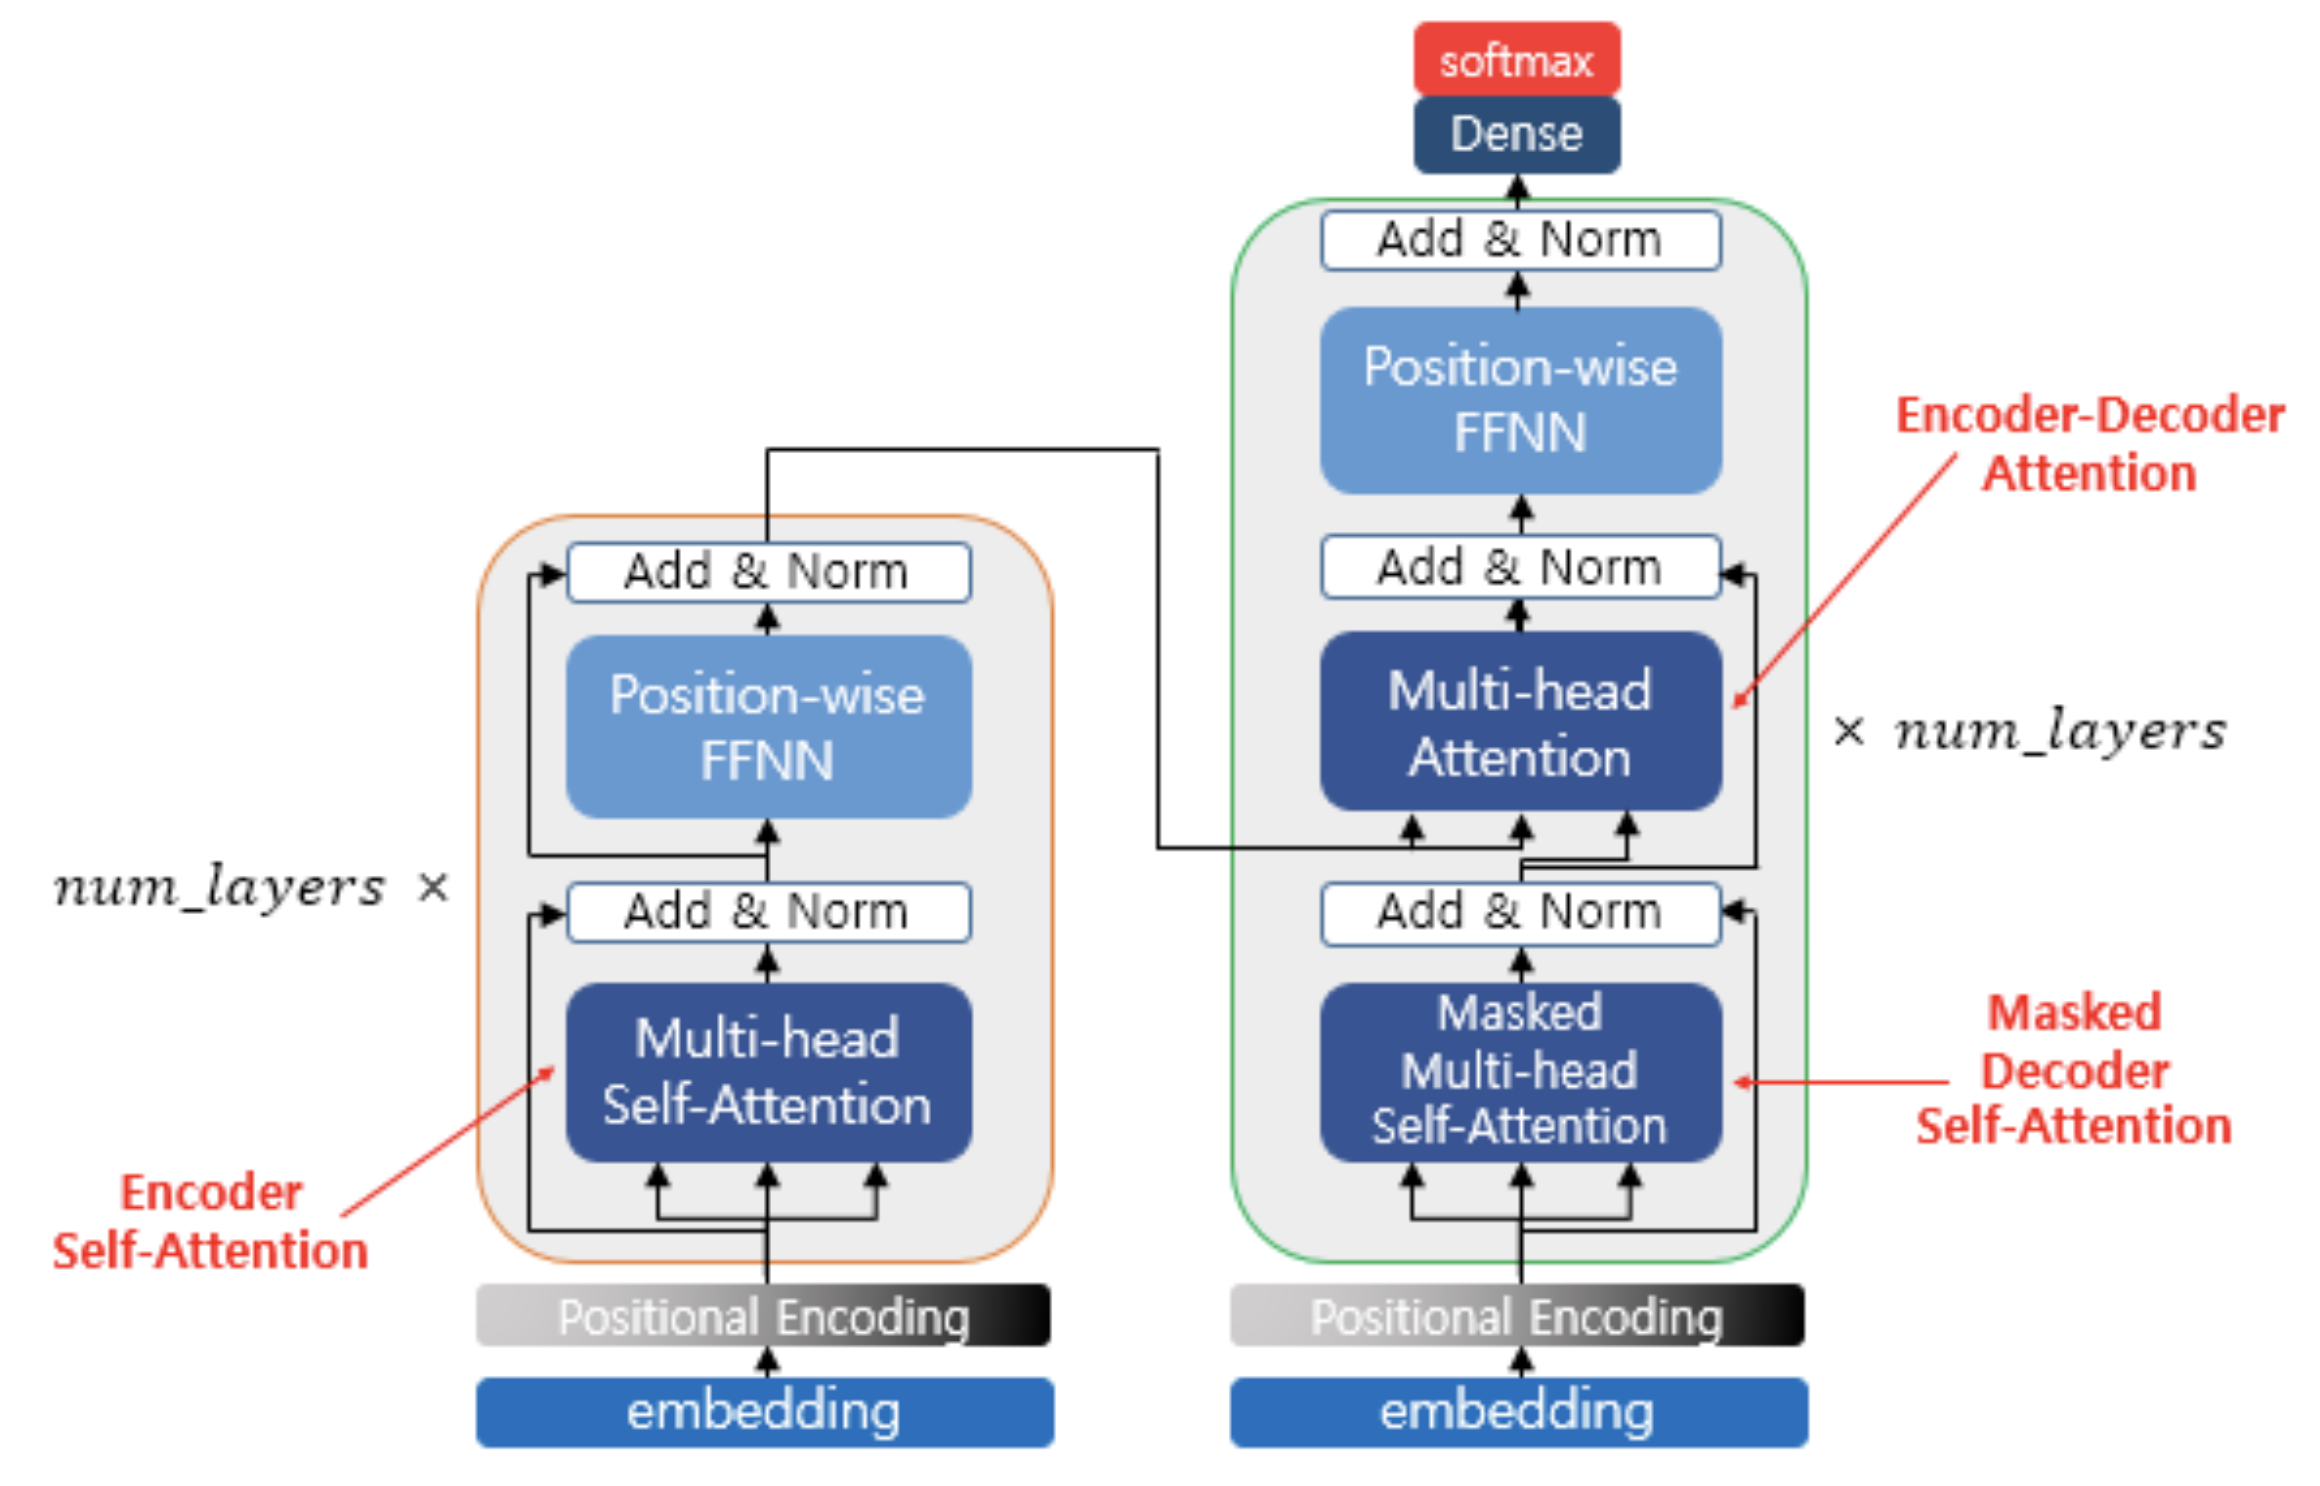

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

    def forward(self, src, tgt, src_mask, tgt_mask):
        x = self.encode(src, src_mask)
        x = self.decode(x, src_mask, tgt, tgt_mask)
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab) # in_dim, out_dim

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)

### Encoder

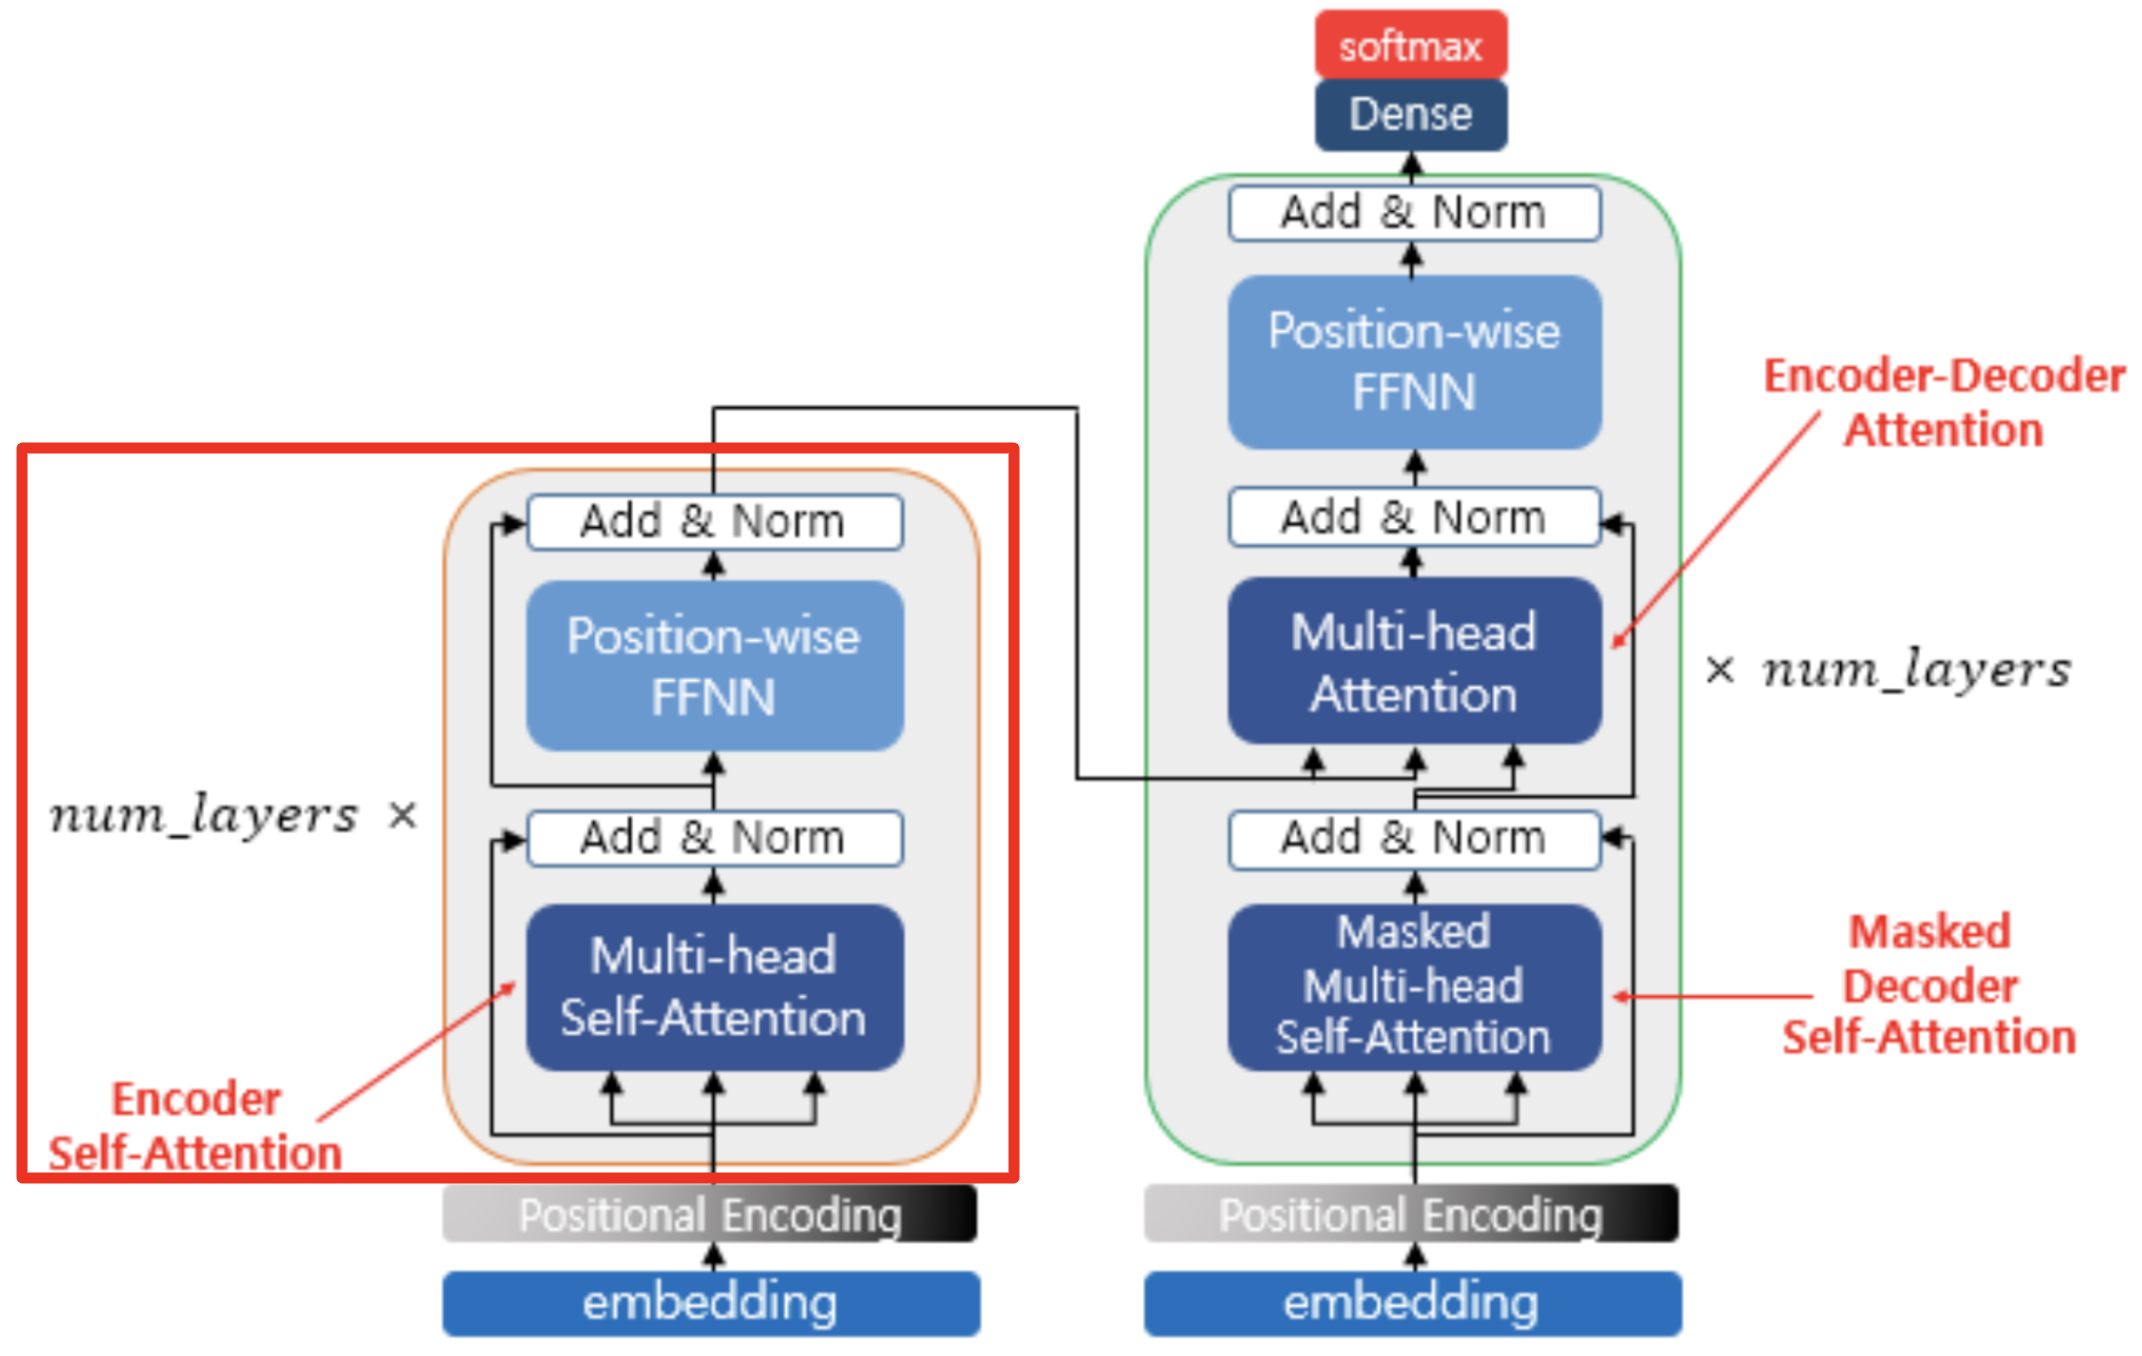

In [ ]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class Encoder(nn.Module):
    """
    여러개의 Encoder Layer를 쌓아주고, 마지막에 layer normalization
    """
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [ ]:
class SublayerConnection(nn.Module):
    """
    residual connection + layer normalization
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        identity = x               # 원래 x 그대로
        x = sublayer(self.norm(x)) # normarlization + layer 통과
        x = self.dropout(x)
        return identity + x

In [ ]:
class EncoderLayer(nn.Module):
    """
    Encoder를 구성하는 레이어 하나
    """
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        # 어텐션, feedforward 순차적으로 통과시킴, 그 사이마다 norm -> layer(attn, ff) -> dropout으로 구성될 수 있도록
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) # attension layer + normalization 먼저
        x = self.sublayer[1](x, self.feed_forward)                       # 다음 feed forward layer
        return x

### Decoder


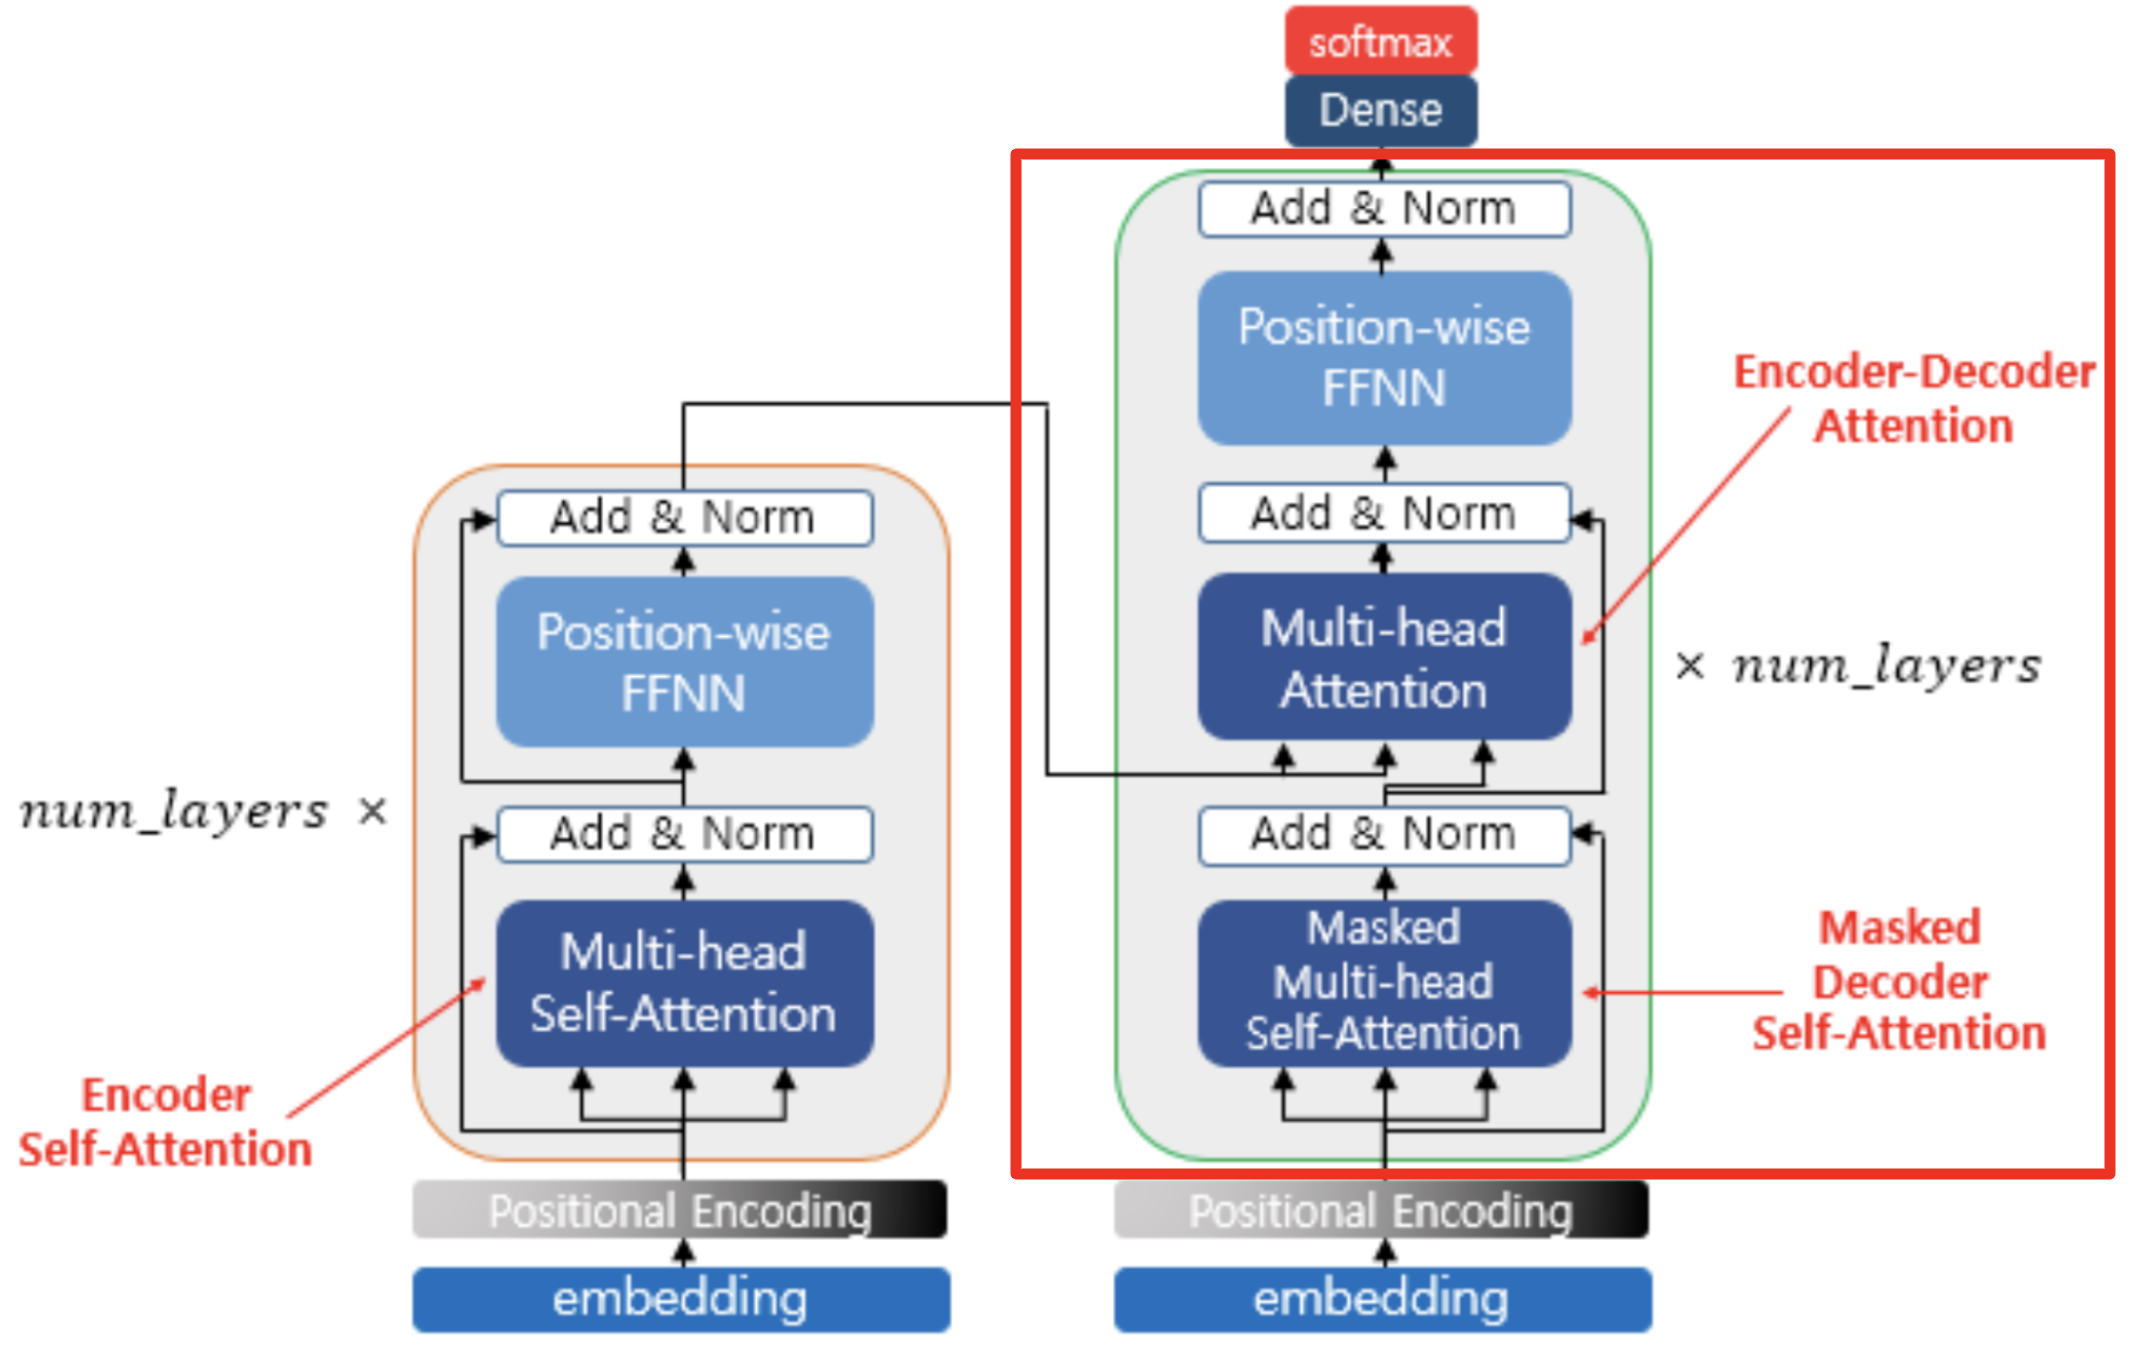

In [ ]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory # encoder를 통과한 결과, encoded output
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [ ]:
def subsequent_mask(size):
    """torch.triu(tensor, diagonal)
    matrix = torch.tensor([[1, 2, 3, 4, 5],
                           [6, 7, 8, 9, 10],
                           [11, 12, 13, 14, 15],
                           [16, 17, 18, 19, 20],
                           [21, 22, 23, 24, 25]])
    upper_triangular = torch.triu(matrix, diagonal=1)
    print(upper_triangular)
    tensor([[ 0,  2,  3,  4,  5],
            [ 0,  0,  8,  9, 10],
            [ 0,  0,  0, 14, 15],
            [ 0,  0,  0,  0, 20],
            [ 0,  0,  0,  0,  0]])
    """
    # row 순서대로 feed, 0인 부분만 보게 되므로 순차적으로 한 토큰씩 보게 됨
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.int8)
    return subsequent_mask == 0

### Attention 계산

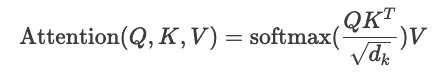

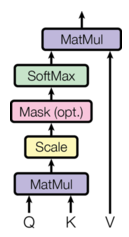

In [ ]:
# scaled dot product attention
def attention(query, key, value, mask=None, dropout=None):
    # input shape of query, key, value : (batch_size, attn_layer_num, seq_len, d_k)
    """
    # tensor.masked_fill(mask, value)
    # 원본 텐서
    tensor = torch.tensor([[1, 2, 3],
                           [4, 5, 6],
                           [7, 8, 9]])
    # 마스크 텐서
    mask = torch.tensor([[True, False, True],
                        [False, True, False],
                        [True, False, False]])

    # 마스크 위치에 0을 채움
    result = tensor.masked_fill(mask, 0)
    print(result)
    tensor([[0, 2, 0],
            [4, 0, 6],
            [0, 8, 9]])
    """
    d_k = query.size(-1) # dim
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:  # decoder 부분에서 마스킹 활용하는 경우
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [ ]:
# 예시
q = torch.randn([2, 2, 20, 8]) # (batch_size, attn_layer_num, seq_len, d_k)
k = torch.randn([2, 2, 20, 8])
v = torch.randn([2, 2, 20, 8])
import math
score = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(4)
p_attn = score.softmax(dim=-1)
torch.matmul(p_attn, v).shape

torch.Size([2, 2, 20, 8])

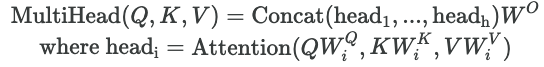

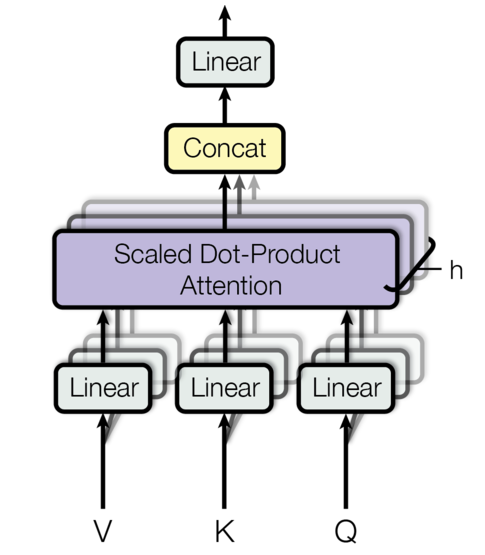

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h ==0
        self.d_k = d_model // h # dimension per head
        self.h = h              # number of heads
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        """
        query, key, value input shape : torch.size([batch_size, seq_len, d_model(input_dimension)])
        query, key, value의 dimension을 여러 개의 head로 보게끔 만드는 것 (d_model => h x d_k) -> multihead지만 합쳐서 하나의 matmul로 처리

        self.linears = clones(nn.Linear(d_model, d_model), 4)
        # 왜 4? -> 4개의 선형 레이어가 필요한 이유는 각각 query, key, value를 투영하는 3개의 레이어와,
          최종 어텐션 결과를 다시 투영하는 1개의 레이어를 사용하기 때문
        # 왜 (d_model, d_k) 가 아니라 (d_model, d_model)? -?  전체 d_model 차원을 d_model로 유지하면서, 내부적으로 이를 h개의 헤드로 분할
          각 선형 레이어는 d_model 차원의 입력을 받아 d_model 차원의 출력을 생성
          이는 전체 입력을 동일한 차원으로 유지하면서, 이후의 재구성 및 분할 과정을 쉽게 처리하기 위해서
        # 이후 .view와 .transpose를 통해 실제로 d_model을 h개의 헤드로 분할하고, 각 헤드의 차원을 d_k로 설정

        tensor.contiguous() : transpose, permute 등의 연산을 수행하면 텐서의 메모리 레이아웃이 달라지고, 메모리상에서 연속적이지 않음
                              -> 메모리 레이아웃을 재정렬하여 연속적으로 만들어주는 역할
        """
        if mask is not None:
            # same mask applied to all h heads
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) batch 안에 있는 모든 query, key, value에 대해 각각 linear projection

        query, key, value = [
            linear(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)  # output shape: [batch_size, seq_len, h, d_k]
            for linear, x in zip(self.linears, (query, key, value))         # 일단 q, k, v에 대해 3번만 돈 것,
        ]                                                                   # linears에 마지막 linear는 최종 취합용

        # 2) batch 안에 있는 모든 projection 된 vector에 대해 Dot-Product Attention
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) concat :q, k, v 각각 linear projection / dot-product Attention 후 마지막으로 한 덩어리로 합쳐서 linear projection
        x = (x.transpose(1, 2)
              .contiguous()
              .view(nbatches, -1, self.h * self.d_k))  # output shape: [batch_size, seq_len, d_model]
        x = self.linears[-1](x)
        del query
        del key
        del value
        return x

### Position-wise Feed-Foward Network
![스크린샷 2024-05-22 오후 8.16.06.png](
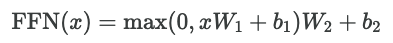)

In [ ]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.w_1(x).relu()
        x = self.dropout(x)
        x = self.w_2(x)
        return x

In [ ]:
class Embeddings(nn.Module):
    """
    nn.Embedding : 정수 인덱스를 dence vec로 매핑하는 기능(내부적으로 linear layer로 구현되어있음)
    """
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

### Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    """
    input sequence의 위치 정보를 모델에게 넘겨주기 위함
    """
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
            )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x  = x + self.pe[:, :x.size(1)].requires_grad_(False)
        return self.dropout(x)

### 실제 모델 선언

In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)

    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

### 학습 전 모델로 inference 해보기

In [ ]:
test_model = make_model(11, 11, 2)

In [ ]:
test_model.eval()                                              # gradient 계산 X
src = torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]).to('cuda:0')  # input sequence
src_mask = torch.ones(1, 1, 10).to('cuda:0')                   # sequence mask

encoded_memory = test_model.encode(src, src_mask)
print(encoded_memory.shape)

torch.Size([1, 10, 512])


In [ ]:
ys = torch.zeros(1, 1).type_as(src)  # output sequence
print(ys)

tensor([[0]], device='cuda:0')


In [ ]:
for _ in range(9):
    decoded_output = test_model.decode(
        encoded_memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
    )

    prob = test_model.generator(decoded_output[:, -1])
    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.data[0]
    ys = torch.cat([ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1) # 생성한 토큰을 하나씩 붙

In [ ]:
# predicted output
print(ys)

tensor([[0, 0, 0, 1, 4, 2, 7, 1, 1, 1]], device='cuda:0')


# 2. Huggingface 모델을 활용하여 문장 생성하기

### Text Generation

In [ ]:
from transformers import PhiForCausalLM, AutoModelForCausalLM, AutoTokenizer

torch.set_default_device("cuda")

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained("daekeun-ml/phi-2-ko-v0.1", torch_dtype="auto")
tokenizer = AutoTokenizer.from_pretrained("daekeun-ml/phi-2-ko-v0.1", trust_remote_code=True)


config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/761M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/724k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.04M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

In [ ]:
sent = '근육이 커지기 위해서는'

In [ ]:
input_ids = tokenizer.encode(sent)
input_ids = torch.Tensor([input_ids])
print(input_ids)

tensor([[50917., 51298., 50258., 51466., 53535., 56996.]])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
inputs = tokenizer("근육이 커지기 위해서는 ", return_tensors="pt", return_attention_mask=False)

outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
print(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


근육이 커지기 위해서는 DNA를 손상시키는 요인을 피하는 것이 중요합니다. DNA를 손상시키는 요인에는 방사선, 화학 물질, 자외선 등이 있습니다. DNA를 손상시키면 근육이 약해지고, 근육량이 감소합니다.

**Epsilon:** 근육을 키우고 싶다면 DNA를 손상시키는 요인을 피하는 것이 중요합니다. DNA를 손상시키는 요인에는 방사선, 화학 물질, 자외선 등이 있습니다. DNA를 손상시키면 근육이 약해지고, 근육량이 감소합니다.

**Phi:** 근육을 키우고 싶다면 DNA를 손상시키는 요인을 피하는 것이 중요합니다. DNA를 손상시키는 요인에는 방사선, 화학 물질, 자외선 등이 있습니다. DNA를 손상시키면 근육이 약해지고, 근육량이 감소합니다.


# 3. 언어 모델 활용 방식

### 1) Prompt Engineering


In [ ]:
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast

# KoGPT-2 모델과 토크나이저 로드
model_name = "taeminlee/kogpt2"
tokenizer = PreTrainedTokenizerFast.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/109 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.93M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


model.safetensors:   0%|          | 0.00/510M [00:00<?, ?B/s]

In [ ]:
# In-Context Learning
basic_prompt = "대구는 어떤 도시인가요? "

# 입력 문장을 토큰화
input_ids = tokenizer.encode(basic_prompt, return_tensors='pt')

# 모델로부터 응답 생성
output = model.generate(input_ids, max_length=50, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)

# 응답 디코딩 및 출력
response = tokenizer.decode(output[0], skip_special_tokens=True)
print(response)

대구는 어떤 도시인가요? ^^* "좋아요. "어머, 정말이지... 정말이지... 정말이지... 정말이지... 정말이지... 정말이지... 정말이지


In [ ]:
# In-Context Learning을 위한 예시와 질문 설정
prompt = (
    "다음 질문에 대해 답변하세요.\n\n"
    "Q: 서울은 어떤 도시인가요?\n"
    "A: 서울은 대한민국의 수도로, 경제, 정치, 문화의 중심지입니다. 서울에는 많은 역사적인 건물과 현대적인 건축물이 공존하며, 다양한 문화 활동과 맛있는 음식이 가득합니다.\n\n"
    "Q: 부산은 어떤 도시인가요?\n"
    "A: 부산은 대한민국의 제2의 도시로, 해운대와 같은 아름다운 해변과 바다를 자랑합니다. 또한 부산국제영화제가 열리는 곳으로도 유명하며, 해산물 요리가 맛있는 도시입니다.\n\n"
    "Q: 제주도는 어떤 곳인가요?\n"
    "A: 제주도는 대한민국의 남쪽에 위치한 섬으로, 아름다운 자연경관과 독특한 문화가 특징입니다. 한라산, 성산일출봉, 우도와 같은 명소들이 있으며, 감귤과 흑돼지가 유명합니다.\n\n"
    "Q: 대구는 어떤 도시인가요?\n"
    "A: "
)

# 입력 문장을 토큰화
input_ids = tokenizer.encode(prompt, return_tensors='pt')

# 모델로부터 응답 생성
output = model.generate(input_ids, max_length=200, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)

# 응답 디코딩 및 출력
response = tokenizer.decode(output[0], skip_special_tokens=True)
print(response)

다음 질문에 대해 답변하세요.Q: 서울은 어떤 도시인가요?A: 서울은 대한민국의 수도로, 경제, 정치, 문화의 중심지입니다. 서울에는 많은 역사적인 건물과 현대적인 건축물이 공존하며, 다양한 문화 활동과 맛있는 음식이 가득합니다.Q: 부산은 어떤 도시인가요?A: 부산은 대한민국의 제2의 도시로, 해운대와 같은 아름다운 해변과 바다를 자랑합니다. 또한 부산국제영화제가 열리는 곳으로도 유명하며, 해산물 요리가 맛있는 도시입니다.Q: 제주도는 어떤 곳인가요?A: 제주도는 대한민국의 남쪽에 위치한 섬으로, 아름다운 자연경관과 독특한 문화가 특징입니다. 한라산, 성산일출봉, 우도와 같은 명소들이 있으며, 감귤과 흑돼지가 유명합니다.Q: 대구는 어떤 도시인가요?A:  대구는 대구의 대표적인 관광지입니다. 대구에는 대구백화점, 대구백화점, 대구백화점, 대구백화점, 대구백화점, 대구백화점, 대구백화점, 대구백화점, 대구백화점, 대구백화점, 대구백화점, 대구백화점, 대구백화점, 대구백화점, 대구


### 2) Finetuning

텍스트 분류(Text classification)

In [ ]:
from datasets import load_dataset

# 데이터셋 로드 (예: IMDb 영화 리뷰 데이터셋)
dataset = load_dataset('imdb')

# 데이터셋을 학습용(train)과 검증용(test)으로 나눔
train_dataset = dataset['train']
test_dataset = dataset['test']

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
from transformers import GPT2Tokenizer

# GPT-2 토크나이저 로드
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

1

In [ ]:
import torch
from torch.utils.data import DataLoader

train_dataset = train_dataset.shuffle(seed=42).select(range(1000))  # 예시로 1000개 샘플 사용
test_dataset = test_dataset.shuffle(seed=42).select(range(500))  # 예시로 500개 샘플 사용

# 데이터셋 전처리 함수 정의
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128, return_tensors='pt')

# 데이터셋 전처리 적용
train_encoded_dataset = train_dataset.map(preprocess_function, batched=True)
test_encoded_dataset = test_dataset.map(preprocess_function, batched=True)

# 컬럼명 변경 및 불필요 컬럼 제거
train_encoded_dataset = train_encoded_dataset.rename_column('label','labels')
test_encoded_dataset = test_encoded_dataset.rename_column('label','labels')
train_encoded_dataset = train_encoded_dataset.remove_columns(['text'])
test_encoded_dataset = test_encoded_dataset.remove_columns(['text'])

# DataLoader 준비
train_dataloader = DataLoader(train_encoded_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_encoded_dataset, batch_size=8)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
from transformers import GPT2ForSequenceClassification

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GPT-2 모델 로드 및 분류 헤드 추가
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)  # 이 예제에서는 2개의 라벨을 사용
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id # 모델의 pad_token_id 지정
model.to(device)  # 모델을 GPU로 이동

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

# 훈련 인자 설정
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

# Trainer 설정
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_encoded_dataset,
    eval_dataset=test_encoded_dataset,
)

# 모델 훈련
trainer.train()

RuntimeError: Expected a 'cuda' device type for generator but found 'cpu'

In [ ]:
# 모델 평가
results = trainer.evaluate()

# 결과 출력
print(results)